# <font color='orange'>  <center> NLP Project: ML Algorithms on Text Data

## <font color='orange'> Each student must extract tweets from twitter. Perform pre-processing and text representation. Apply ML algorithms for classification/clustering. <br> <br> 1. Creating Datasets <dd> a. Extract 5000 tweets with any 5 search labels of your choice. (1000 each). Eg(#cricket, #football, #basketball, #tennis, #hockey). <dd> b. Create one dataset for all the tweets extracted along with labels as second column. Shuffle the dataset. </dd> <br> <br>2. Pre-processing <dd> a. Clean the data by removing tags, user handles, numbers, and other characters. <dd> b. Stem tokens for basic vectorization <dd> c. Lemma tokens for embeddings </dd> <br> <br> 3. Text representation <dd> a. Vectorise each document in the dataset with tf-idf vectorization with n-grams (use stemmed data). <dd> b. Create document embeddings by summation of word vectors taken from any two pre-trained models. The tokens must be lemmas. </dd> <br> <br> 4. Apply machine learning techniques (any two algorithms) for classification/clustering on <dd> a. 3.a data <dd> b. 3.b data </dd> <br> <br> 5. Evaluate the results (4.a and 4.b) which outperforms. <dd> a. For clustering compare at least 10 records’ label with the clusters created. <dd> b. Present a chart as for classification:

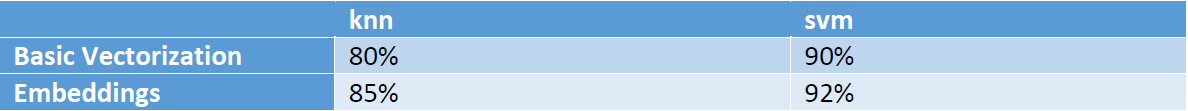

In [1]:
import twitter_info

import tweepy
from imdb import IMDb

import time
import json
import pandas as pd
import numpy as np
from iteration_utilities import deepflatten
from datetime import datetime
import os
import re
import glob
from tqdm import tqdm

from nltk.tokenize import word_tokenize
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer
pm = PorterStemmer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import codecs
from glove import Corpus, Glove
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import FastText

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sn

from pickle import dump
from pickle import load

G:\anaconda\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
%run helper_functions.ipynb

In [3]:
consumer_key = twitter_info.API_Key
consumer_secret = twitter_info.API_Key_Secret
access_token = twitter_info.Access_Token
access_token_secret = twitter_info.Access_Token_Secret
bearer_token = twitter_info.Bearer_Token

In [4]:
client = tweepy.Client(bearer_token = bearer_token)
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
API = tweepy.API(auth, wait_on_rate_limit=True, retry_count=5, retry_delay=180)

In [5]:
s = str(datetime.now())
s = s[:16].replace(" ", "_").replace(":","")

In [6]:
class_list = ['Star Wars','Marvel Cinematic Universe','MonsterVerse','Wizarding World','DC Extended Universe']
class_query_list = []
class_file_name = ['input/star_wars_keywords.txt', 'input/Marvel_Cinematic_Universe_MCU_keywords.txt', 
                   'input/MonsterVerse_keywords.txt', 'input/Wizarding_World_keywords.txt', 'input/DC_Extended_Universe_keywords.txt']
class_keyword_list = []
for i in range(len(class_list)):
    with open(class_file_name[i]) as f:
        class_keyword_list.append(f.readlines())
    class_keyword_list[i] = [key_word.strip() + ' OR ' for key_word in class_keyword_list[i]]
    class_temp = ''.join(class_keyword_list[i])
    class_query_list.append(class_temp[:-4])

In [7]:
for i in range(len(class_list)):
    print("\n", class_query_list[i], class_list[i], len(class_query_list[i]), "\n")


 "Star Wars" OR "Darth Vader" OR "Obi-Wan Kenobi" OR "Yoda" OR "Princess Leia" OR "R2-D2" OR "Chewbacca" OR "Darth Maul" OR "C-3PO" OR "Q ira" OR "Uncle Owen" OR "Admiral Ackbar" OR "Jabba Hut" OR "Skywalker" OR "A New Hope" OR "Empire Strikes Back" OR "Return Jedi" OR "Phantom Menace" OR "Attack Clones" OR "Revenge Sith" OR "Force Awakens" OR "Last Jedi" OR "Clone Wars" Star Wars 372 


 "Marvel Cinematic Universe" OR "MCU" OR "Thor" OR "Ant Man" OR "Falcon" OR "Hulk" OR "Luke Cage" OR "Doctor Strange" OR "Groot" OR "Punisher" OR "Black Widow" OR "Jessica Jones" OR "Dare devil" OR "Captain America" OR "Loki" OR "Black Panther" OR "Spider Man" OR "Iron Man" OR "Scarlet Witch" OR "Captain Marvel" OR "Hawkeye" OR "Star Lord" OR "Thanos" OR "Eternals" OR "The Avengers" OR "Guardians of the Galaxy" Marvel Cinematic Universe 413 


 "MonsterVerse" OR "King Kong" OR "Anguirus" OR "Godzilla" OR "MechaKing Ghidorah" OR "Mechagodzilla" OR "King Ghidorah" OR "MUTO" OR "Monster X" OR "Mothra" OR

In [8]:
important_key_words = []
for i in range(len(class_list)):
    with open(class_file_name[i]) as f:
        lines = f.readlines()
        lines = [l.split() for l in lines]
        important_key_words.extend(lines)
important_key_words = list(deepflatten(important_key_words, depth=1))
important_key_words = [k.strip('"') for k in important_key_words]
print(important_key_words[:10])

['Star', 'Wars', 'Darth', 'Vader', 'Obi-Wan', 'Kenobi', 'Yoda', 'Princess', 'Leia', 'R2-D2']


In [9]:
print(len(important_key_words))
txt = " ".join(important_key_words)
selected_tags = []
processed_key_words_stem = preprocess_doc(txt, stem=True, lemma=False, stop_wrds=True, selected_tags=selected_tags)
print(len(processed_key_words_stem))
print(processed_key_words_stem)

216
199
['star', 'war', 'darth', 'vader', 'obi-wan', 'kenobi', 'yoda', 'princess', 'leia', 'chewbacca', 'darth', 'maul', 'ira', 'uncl', 'owen', 'admir', 'ackbar', 'jabba', 'hut', 'skywalk', 'new', 'hope', 'empir', 'strike', 'back', 'return', 'jedi', 'phantom', 'menac', 'attack', 'clone', 'reveng', 'sith', 'forc', 'awaken', 'last', 'jedi', 'clone', 'war', 'marvel', 'cinemat', 'univers', 'mcu', 'thor', 'ant', 'man', 'falcon', 'hulk', 'luke', 'cage', 'doctor', 'strang', 'groot', 'punish', 'black', 'widow', 'jessica', 'jone', 'dare', 'devil', 'captain', 'america', 'loki', 'black', 'panther', 'spider', 'man', 'iron', 'man', 'scarlet', 'witch', 'captain', 'marvel', 'hawkey', 'star', 'lord', 'thano', 'etern', 'aveng', 'guardian', 'galaxi', 'monstervers', 'king', 'kong', 'anguiru', 'godzilla', 'mechak', 'ghidorah', 'mechagodzilla', 'king', 'ghidorah', 'muto', 'monster', 'mothra', 'preston', 'packard', 'alan', 'jonah', 'emma', 'russel', 'mark', 'russel', 'jame', 'conrad', 'mason', 'weaver', 'fo

In [10]:
print(len(important_key_words))
txt = " ".join(important_key_words)
selected_tags = []
processed_key_words_lemma = preprocess_doc(txt, stem=False, lemma=True, stop_wrds=True, selected_tags=selected_tags)
print(len(processed_key_words_lemma))
print(processed_key_words_lemma)

216
199
['star', 'war', 'darth', 'vader', 'obi-wan', 'kenobi', 'yoda', 'princess', 'leia', 'chewbacca', 'darth', 'maul', 'ira', 'uncle', 'owen', 'admiral', 'ackbar', 'jabba', 'hut', 'skywalker', 'new', 'hope', 'empire', 'strike', 'back', 'return', 'jedi', 'phantom', 'menace', 'attack', 'clone', 'revenge', 'sith', 'force', 'awakens', 'last', 'jedi', 'clone', 'war', 'marvel', 'cinematic', 'universe', 'mcu', 'thor', 'ant', 'man', 'falcon', 'hulk', 'luke', 'cage', 'doctor', 'strange', 'groot', 'punisher', 'black', 'widow', 'jessica', 'jones', 'dare', 'devil', 'captain', 'america', 'loki', 'black', 'panther', 'spider', 'man', 'iron', 'man', 'scarlet', 'witch', 'captain', 'marvel', 'hawkeye', 'star', 'lord', 'thanos', 'eternals', 'avenger', 'guardian', 'galaxy', 'monsterverse', 'king', 'kong', 'anguirus', 'godzilla', 'mechaking', 'ghidorah', 'mechagodzilla', 'king', 'ghidorah', 'muto', 'monster', 'mothra', 'preston', 'packard', 'alan', 'jonah', 'emma', 'russell', 'mark', 'russell', 'james', 

In [11]:
%%time
for i in range(len(class_list)):
    print("\n", class_query_list[i], class_list[i], "\n")
    extract_tweets(class_query_list[i], class_list[i], fresh_load = False)


 "Star Wars" OR "Darth Vader" OR "Obi-Wan Kenobi" OR "Yoda" OR "Princess Leia" OR "R2-D2" OR "Chewbacca" OR "Darth Maul" OR "C-3PO" OR "Q ira" OR "Uncle Owen" OR "Admiral Ackbar" OR "Jabba Hut" OR "Skywalker" OR "A New Hope" OR "Empire Strikes Back" OR "Return Jedi" OR "Phantom Menace" OR "Attack Clones" OR "Revenge Sith" OR "Force Awakens" OR "Last Jedi" OR "Clone Wars" Star Wars 

Tweets extracted in output/tweets/ folder

 "Marvel Cinematic Universe" OR "MCU" OR "Thor" OR "Ant Man" OR "Falcon" OR "Hulk" OR "Luke Cage" OR "Doctor Strange" OR "Groot" OR "Punisher" OR "Black Widow" OR "Jessica Jones" OR "Dare devil" OR "Captain America" OR "Loki" OR "Black Panther" OR "Spider Man" OR "Iron Man" OR "Scarlet Witch" OR "Captain Marvel" OR "Hawkeye" OR "Star Lord" OR "Thanos" OR "Eternals" OR "The Avengers" OR "Guardians of the Galaxy" Marvel Cinematic Universe 

Tweets extracted in output/tweets/ folder

 "MonsterVerse" OR "King Kong" OR "Anguirus" OR "Godzilla" OR "MechaKing Ghidorah" O

In [12]:
df_all_tweet_list = []
class_output_files = []
list_output_files = [os.getcwd()+"\\output\\tweets\\"+f for f in os.listdir("output/tweets/")]
def find_label(file_name):
    for c in class_list:
        if(file_name.find(c) >= 0):
            return c
    return None
for f in list_output_files:
    class_output_files.append([find_label(f), f])
class_output_files

[['DC Extended Universe',
  'C:\\spark\\MCA\\Semester 1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_DC Extended Universe_2022-04-05_0332.csv'],
 ['Marvel Cinematic Universe',
  'C:\\spark\\MCA\\Semester 1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_Marvel Cinematic Universe_2022-04-05_0332.csv'],
 ['MonsterVerse',
  'C:\\spark\\MCA\\Semester 1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_MonsterVerse_2022-04-05_0332.csv'],
 ['Star Wars',
  'C:\\spark\\MCA\\Semester 1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_Star Wars_2022-04-05_0332.csv'],
 ['Wizarding World',
  'C:\\spark\\MCA\\Semester 1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_Wizarding World_2022-04-05_0332.csv']]

In [13]:
def get_full_text(label, file_name):
    df_temp = pd.read_csv(file_name)
    df_temp['label'] = label
    return df_temp[['full_text','label']]
class_tweet_list = []
for val in class_output_files:
    df_tweet_label = get_full_text(val[0], val[1])
    class_tweet_list.append(df_tweet_label)

In [14]:
final_tweet_df = pd.concat(class_tweet_list, axis=0, ignore_index=True)
final_tweet_df.to_csv("output/final_output/full_tweet_list.csv", index = False)
final_tweet_df

,full_text,label
0,Barnes &amp; Noble Pickup\n\nBarnes and Noble ...,DC Extended Universe
1,The True Crime Podcasts in the Batman universe...,DC Extended Universe
2,Want a free December's Dream Set!?❄🎀\nFollow m...,DC Extended Universe
3,I'm about to put some of my original artwork u...,DC Extended Universe
4,@Darmson2 @ALMUBAR04 @MUFC_Boogie @king_polams...,DC Extended Universe
...,...,...
49795,@essteeem Harry Potter movie series,Wizarding World
49796,my heart aches reminiscing ot/12 era (minus vo...,Wizarding World
49797,@bfsnailea Harry Potter,Wizarding World
49798,Next. #Hogwartle 92 3/6\n\n⬜⬜⬜⬜⬜\n🟩🟩⬜⬜⬜\n🟩🟩🟩🟩🟩...,Wizarding World


In [15]:
df_movies_id = pd.read_csv("input/imdb_movie_list.csv")
df_movies_id

,Universe,Movie_Name,IMDB_Movie_Id,Movie_Name_Key
0,Star Wars,A New Hope,76759,star_wars_a_new_hope
1,Star Wars,The Empire Strikes Back,80684,star_wars_the_empire_strikes_back
2,Star Wars,Return of the Jedi,86190,star_wars_episode_vi_return_of_the_jedi
3,Star Wars,The Phantom Menace,120915,star_wars_episode_i_the_phantom_menace
4,Star Wars,Attack of the Clones,121765,star_wars_episode_ii_attack_of_the_clones
...,...,...,...,...
59,Wizarding World,Harry Potter and the Half-Blood Prince,417741,harry_potter_and_the_half_blood_prince
60,Wizarding World,Harry Potter and the Deathly Hallows – Part 1,926084,harry_potter_and_the_deathly_hallows_part_1
61,Wizarding World,Harry Potter and the Deathly Hallows – Part 2,1201607,harry_potter_and_the_deathly_hallows_part_2
62,Wizarding World,Fantastic Beasts and Where to Find Them,3183660,fantastic_beasts_and_where_to_find_them


In [16]:
fresh_load=False
extract_imdb_reviews(df_movies_id, fresh_load)

Extracted IMDB reviews to output/final_output/full_imdb_review_list.csv


In [17]:
final_imdb_df = pd.read_csv("output/final_output/full_imdb_review_list.csv")
final_imdb_df.head()

,full_text,label
0,Henry Cavil is my Superman. He's the best Supe...,DC Extended Universe
1,"A QUICK "" DVD-REVIEW "" .HENRY CAVILL ⭐ CARRIES...",DC Extended Universe
2,Hands down the best Superman movie out there. ...,DC Extended Universe
3,At first I was very nervous at the prospect of...,DC Extended Universe
4,So we are looking at essentially a remake of S...,DC Extended Universe


In [18]:
final_input_df = pd.concat([final_imdb_df,final_tweet_df], axis=0, ignore_index=True)
final_input_df = final_input_df.sample(frac=1, random_state=42).reset_index(drop=True)    ## Shuffling Dataframe
final_input_df.to_csv("output/final_output/final_input_df.csv", index = False)

In [19]:
final_input_df = pd.read_csv("output/final_output/final_input_df.csv")
final_input_df

,full_text,label
0,‘#GuardiansoftheGalaxy 3’ Star #KarenGillan Sa...,Marvel Cinematic Universe
1,My friend recommend me a few shows and I have ...,DC Extended Universe
2,@Papa__Drago Godzilla would win easily but jus...,MonsterVerse
3,Batman &amp; Robin...It's so camp https://t.co...,DC Extended Universe
4,why is huge ant man moving so slow,Marvel Cinematic Universe
...,...,...
51457,@tortoisethatwon @aightmoe @Sarcasm_bender End...,DC Extended Universe
51458,@iHrtProngs SIRIUS BLACK DOES NOT HAVE A BAD H...,Wizarding World
51459,@aNorthernGarden @fiona_skywalker Agreed. She ...,Star Wars
51460,And so my long Marvel-watching journey comes t...,Marvel Cinematic Universe


In [20]:
tags = nltk.data.load('help/tagsets/upenn_tagset.pickle')
#nltk.help.upenn_tagset()
#selected_tags = ['NN','NNP','NNPS','NNS','JJ','JJR','JJS']
selected_tags = ['NN','NNP','NNPS','NNS']

In [21]:
sample_text = final_input_df['full_text'][2]
print(pos_tag(word_tokenize(sample_text)))
print(sample_text)
sample_text = preprocess_doc(sample_text, False, True, True, selected_tags)
print(sample_text)

[('@', 'NN'), ('Papa__Drago', 'NNP'), ('Godzilla', 'NNP'), ('would', 'MD'), ('win', 'VB'), ('easily', 'RB'), ('but', 'CC'), ('just', 'RB'), ('seeing', 'VBG'), ('him', 'PRP'), ('tear', 'VB'), ('through', 'IN'), ('hundreds', 'NNS'), ('of', 'IN'), ('titans', 'NNS'), ('WOULD', 'NNP'), ('BE', 'NNP'), ('SO', 'NNP'), ('FREAKING', 'NNP'), ('COOL', 'NNP'), ('!', '.'), ('OMG', 'NN')]
@Papa__Drago Godzilla would win easily but just seeing him tear through hundreds of titans WOULD BE SO FREAKING COOL! OMG
['papa', 'drago', 'godzilla', 'titan', 'omg']


In [22]:
extract_stems_lemma(selected_tags, final_input_df, fresh_load= False)

Stems and Lemma extracted to output/final_output/final_input_cleaned_stem_lemma.csv


In [23]:
final_input_df = pd.read_csv("output/final_output/final_input_cleaned_stem_lemma.csv")

In [24]:
final_input_df['label_id'] = final_input_df['label'].astype("category").cat.codes
final_input_df

,full_text,label,stem_cleaned_tokens,lemma_cleaned_tokens,label_id
0,‘#GuardiansoftheGalaxy 3’ Star #KarenGillan Sa...,Marvel Cinematic Universe,"['guardiansofthegalaxi', 'star', 'karengillan'...","['guardiansofthegalaxy', 'star', 'karengillan'...",1
1,My friend recommend me a few shows and I have ...,DC Extended Universe,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...","['friend', 'show', 'idea', 'flash', 'guy', 'sh...",0
2,@Papa__Drago Godzilla would win easily but jus...,MonsterVerse,"['papa', 'drago', 'godzilla', 'hundr', 'titan'...","['papa', 'drago', 'godzilla', 'titan', 'omg']",2
3,Batman &amp; Robin...It's so camp https://t.co...,DC Extended Universe,"['batman', 'robin', 'camp']","['batman', 'robin', 'camp']",0
4,why is huge ant man moving so slow,Marvel Cinematic Universe,"['ant', 'man', 'move']","['ant', 'man']",1
...,...,...,...,...,...
51457,@tortoisethatwon @aightmoe @Sarcasm_bender End...,DC Extended Universe,"['tortoisethatwon', 'aightmo', 'sarcasm', 'ben...","['tortoisethatwon', 'aightmoe', 'sarcasm', 'be...",0
51458,@iHrtProngs SIRIUS BLACK DOES NOT HAVE A BAD H...,Wizarding World,"['hair', 'day']","['ihrtprongs', 'hair', 'day']",4
51459,@aNorthernGarden @fiona_skywalker Agreed. She ...,Star Wars,"['fiona', 'skywalk', 'liter', 'ask', 'comment'...","['fiona', 'skywalker', 'input', 'earns', 'hous...",3
51460,And so my long Marvel-watching journey comes t...,Marvel Cinematic Universe,"['marvel-watch', 'journey', 'caught', 'endless...","['journey', 'end', 'franchise', 'eon', 'rest',...",1


In [25]:
df_vectorization = final_input_df[['stem_cleaned_tokens', 'label', 'label_id']]
df_vectorization.head()

,stem_cleaned_tokens,label,label_id
0,"['guardiansofthegalaxi', 'star', 'karengillan'...",Marvel Cinematic Universe,1
1,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...",DC Extended Universe,0
2,"['papa', 'drago', 'godzilla', 'hundr', 'titan'...",MonsterVerse,2
3,"['batman', 'robin', 'camp']",DC Extended Universe,0
4,"['ant', 'man', 'move']",Marvel Cinematic Universe,1


In [26]:
dfvg = df_vectorization.groupby(['label', 'label_id'])
classes = {}
for d in dfvg:
    classes[d[0][1]] = d[0][0]
print(classes)

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}


In [27]:
df_embedding = final_input_df[['lemma_cleaned_tokens', 'label', 'label_id']]
df_embedding.head()

,lemma_cleaned_tokens,label,label_id
0,"['guardiansofthegalaxy', 'star', 'karengillan'...",Marvel Cinematic Universe,1
1,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...",DC Extended Universe,0
2,"['papa', 'drago', 'godzilla', 'titan', 'omg']",MonsterVerse,2
3,"['batman', 'robin', 'camp']",DC Extended Universe,0
4,"['ant', 'man']",Marvel Cinematic Universe,1


In [28]:
len(df_embedding)

51462

In [29]:
%%time
list_stemmed_data = []
list_embedding_data = []
for i in df_vectorization.index:
    exec("lst = " + df_vectorization['stem_cleaned_tokens'][i])
    lst = clean_tokens(lst)
    list_stemmed_data.append(" ".join(lst))
    exec("lst2 = " + df_embedding['lemma_cleaned_tokens'][i])
    lst2 = clean_tokens(lst2)
    list_embedding_data.append(" ".join(lst2))

CPU times: total: 6.88 s
Wall time: 6.89 s


# <font color='orange'>  <center> Basic Vectorization

In [30]:
%%time
tf_idf_vectorizer = TfidfVectorizer(ngram_range = (1,3), analyzer='word', min_df=2)
vectorized_text=tf_idf_vectorizer.fit_transform(list_stemmed_data)

CPU times: total: 2.34 s
Wall time: 2.41 s


In [31]:
tf_idf_vectors = tf_idf_vectorizer.get_feature_names_out()
tf_idf_vectors

array(['abaddon', 'abaga', 'abaga eniolamaf', ..., 'zuri whitak',
       'zxshadowacexz', 'zypisfi'], dtype=object)

In [32]:
len(tf_idf_vectors)

84351

In [33]:
dump(tf_idf_vectorizer,open('models/tfidf_stem_vector.pkl', 'wb'))

In [34]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))

In [35]:
%%time
X_sv=vectorized_text
y_sv=list(df_vectorization['label_id'])
print(X_sv.shape)
print(len(y_sv))
X_train_sv, X_valid_sv, y_train_sv, y_valid_sv = train_test_split(X_sv, y_sv, test_size = 0.3, shuffle = True, stratify = y_sv, random_state = 3)

(51462, 84351)
51462
CPU times: total: 31.2 ms
Wall time: 29.1 ms


# <font color='orange'>  <center> TFIDF Multinomial Naive Bayes model

Train Accuracy Score of TFIDF Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.9618299419815118
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of TFIDF Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.9154090290821945
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2682  232   55   52   35]
 [ 127 2918   39   73   54]
 [  92  133 2725   45   36]
 [  40   82   25 2878   38]
 [  32   68   17   31 2930]]


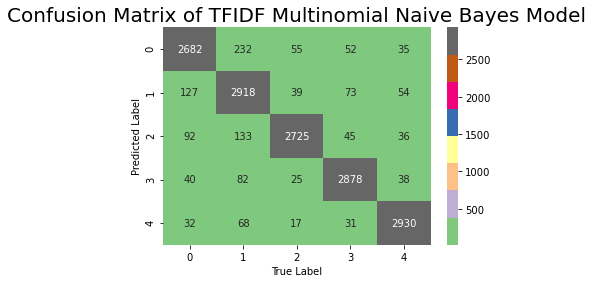

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.90      0.88      0.89      3056\n'
 '           1       0.85      0.91      0.88      3211\n'
 '           2       0.95      0.90      0.92      3031\n'
 '           3       0.93      0.94      0.94      3063\n'
 '           4       0.95      0.95      0.95      3078\n'
 '\n'
 '    accuracy                           0.92     15439\n'
 '   macro avg       0.92      0.92      0.92     15439\n'
 'weighted avg       0.92      0.92      0.92     15439\n')
CPU times: total: 344 ms
Wall time: 589 ms


In [36]:
%%time
tfidf_mnb_model = MultinomialNB()
tfidf_mnb_model, score_tfidf_mnb = evaluate_model(X_train_sv, y_train_sv, X_valid_sv, y_valid_sv, classes, 
                                         tfidf_mnb_model, "TFIDF Multinomial Naive Bayes", "tfidf_mnb_model.pkl", fresh_load=False)

In [37]:
get_cross_val(tfidf_mnb_model, X_train_sv, y_train_sv, X_valid_sv, y_valid_sv)

Cross validation over 10 folds:  0.9140825871092986


array([1, 2, 0, ..., 2, 0, 0])

In [38]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_mnb_model = load(open('models/tfidf_mnb_model.pkl', 'rb'))

In [39]:
output_file_name = "input/rottentomatoes_reviews_final.csv"
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [40]:
df_rottentomatoes_reviews[["review", "label_name"]]

,review,label_name
0,"2019's Godzilla: King of the Monsters, does pr...",MonsterVerse
1,"Shazam!, it's wonderful. It's a very well-dire...",DC Extended Universe
2,The crimes of Grindelwald is a very good film ...,Wizarding World
3,An entertaining film with a great villain and ...,Marvel Cinematic Universe
4,Captain America: Civil War goes a darker direc...,Marvel Cinematic Universe
...,...,...
260,Shazam is fun and entertaining! It succeeds in...,DC Extended Universe
261,Godzilla: King of the Monsters was the first M...,MonsterVerse
262,"Not quite top tier MCU, but very close. This i...",Marvel Cinematic Universe
263,There are a lot of mixed feeling about this mo...,Marvel Cinematic Universe


In [41]:
%%time
classes = {0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
test_tfidf_vec_list = []
for i in df_rottentomatoes_reviews.index:
    test_text = df_rottentomatoes_reviews["review"][i]
    test_text = preprocess_doc(test_text, stem = True, lemma = False, stop_wrds = True, selected_tags = selected_tags)
    vec = tf_idf_vectorizer.transform(test_text)
    test_tfidf_vec_list.append(vec)

CPU times: total: 12.3 s
Wall time: 12.3 s


In [42]:
%%time
test_acc_scr_tfidf_mnb, df_rottentomatoes_reviews = test_model(tfidf_mnb_model, "TFIDF Multinomial Naive Bayes", "tfidf_MNB", df_rottentomatoes_reviews, test_tfidf_vec_list)

Test Accuracy Score of TFIDF Multinomial Naive Bayes Model created using stemmed tf_idf vector is:
 0.7433962264150943
CPU times: total: 484 ms
Wall time: 472 ms


In [43]:
df_rottentomatoes_reviews.to_csv("output/final_output/df_rottentomatoes_reviews_predicted"+s+".csv", index = False)
df_rottentomatoes_reviews

,review,movie_name,label_name,predicted_label_MNB,y_true,y_pred_MNB,predicted_label_tfidf_rfc,y_pred_tfidf_rfc,predicted_label_tfidf_MNB,y_pred_tfidf_MNB
0,"2019's Godzilla: King of the Monsters, does pr...",godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2
1,"Shazam!, it's wonderful. It's a very well-dire...",shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,Marvel Cinematic Universe,1
2,The crimes of Grindelwald is a very good film ...,fantastic_beasts_the_crimes_of_grindelwald,Wizarding World,Wizarding World,4,4,MonsterVerse,2,DC Extended Universe,0
3,An entertaining film with a great villain and ...,spider_man_homecoming,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
4,Captain America: Civil War goes a darker direc...,captain_america_civil_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
...,...,...,...,...,...,...,...,...,...,...
260,Shazam is fun and entertaining! It succeeds in...,shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,DC Extended Universe,0
261,Godzilla: King of the Monsters was the first M...,godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2
262,"Not quite top tier MCU, but very close. This i...",avengers_infinity_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,DC Extended Universe,0,Marvel Cinematic Universe,1
263,There are a lot of mixed feeling about this mo...,thor_the_dark_world,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,DC Extended Universe,0,Marvel Cinematic Universe,1


# <font color='orange'>  <center> TFIDF Support Vector Classifier

Train Accuracy Score of TFIDF Support Vector Classifier model created using stemmed tf_idf vector is:
 0.9895344640923854
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of TFIDF Support Vector Classifier model created using stemmed tf_idf vector is:
 0.9172226180452102
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2753  262   15   15   11]
 [ 171 2983   16   29   12]
 [ 132  183 2696   14    6]
 [  72  126   10 2838   17]
 [  50  102   10   25 2891]]


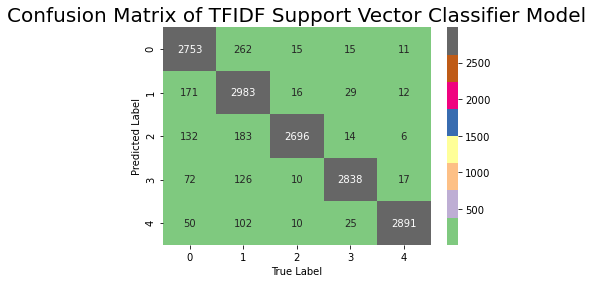

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.87      0.90      0.88      3056\n'
 '           1       0.82      0.93      0.87      3211\n'
 '           2       0.98      0.89      0.93      3031\n'
 '           3       0.97      0.93      0.95      3063\n'
 '           4       0.98      0.94      0.96      3078\n'
 '\n'
 '    accuracy                           0.92     15439\n'
 '   macro avg       0.92      0.92      0.92     15439\n'
 'weighted avg       0.92      0.92      0.92     15439\n')
CPU times: total: 2min 23s
Wall time: 2min 24s


In [44]:
%%time
tfidf_svc_model = SVC()
tfidf_svc_model, score_tfidf_svc = evaluate_model(X_train_sv, y_train_sv, X_valid_sv, y_valid_sv, classes, 
                                         tfidf_svc_model, "TFIDF Support Vector Classifier", "tfidf_svc_model.pkl", fresh_load=False)

In [45]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_svc_model = load(open('models/tfidf_svc_model.pkl', 'rb'))

In [46]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [47]:
%%time
test_acc_scr_tfidf_svc, df_rottentomatoes_reviews = test_model(tfidf_svc_model, "TFIDF Support Vector Classifier", "tfidf_svc", df_rottentomatoes_reviews, test_tfidf_vec_list)

Test Accuracy Score of TFIDF Support Vector Classifier Model created using stemmed tf_idf vector is:
 0.6490566037735849
CPU times: total: 16.6 s
Wall time: 16.6 s


In [48]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> TFIDF KNN Classifier

Train Accuracy Score of TFIDF K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.6454765011242817
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of TFIDF K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.4653798821167174
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[1759  708  387   67  135]
 [ 905 1724  396   68  118]
 [ 857  779 1235   48  112]
 [ 712  627  369 1248  107]
 [ 720  680  397   62 1219]]


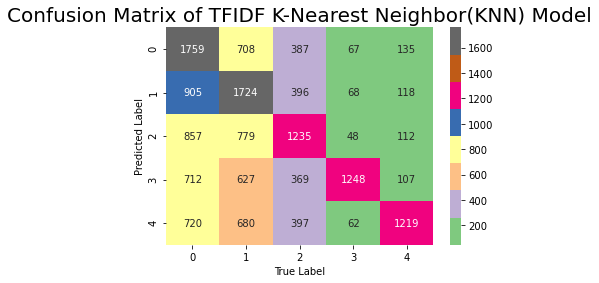

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.36      0.58      0.44      3056\n'
 '           1       0.38      0.54      0.45      3211\n'
 '           2       0.44      0.41      0.42      3031\n'
 '           3       0.84      0.41      0.55      3063\n'
 '           4       0.72      0.40      0.51      3078\n'
 '\n'
 '    accuracy                           0.47     15439\n'
 '   macro avg       0.55      0.46      0.47     15439\n'
 'weighted avg       0.55      0.47      0.47     15439\n')
CPU times: total: 57.3 s
Wall time: 57.6 s


In [49]:
%%time
tfidf_knn_model = KNeighborsClassifier(5)
tfidf_knn_model, score_tfidf_knn = evaluate_model(X_train_sv, y_train_sv, X_valid_sv, y_valid_sv, classes, 
                                         tfidf_knn_model, "TFIDF K-Nearest Neighbor(KNN)", "tfidf_knn_model.pkl", fresh_load=False)

In [50]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_knn_model = load(open('models/tfidf_knn_model.pkl', 'rb'))

In [51]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [52]:
%%time
test_acc_scr_tfidf_knn, df_rottentomatoes_reviews = test_model(tfidf_knn_model, "TFIDF K-Nearest Neighbor(KNN)", "tfidf_knn", df_rottentomatoes_reviews, test_tfidf_vec_list)

Test Accuracy Score of TFIDF K-Nearest Neighbor(KNN) Model created using stemmed tf_idf vector is:
 0.5471698113207547
CPU times: total: 13.4 s
Wall time: 13.4 s


In [53]:
#%%time
#get_cross_val(tfidf_knn_model, X_train_sv, y_train_sv, X_valid_sv, y_valid_sv)

In [54]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> TFIDF Random Forest Classifier

Train Accuracy Score of TFIDF Random Forest Classifier model created using stemmed tf_idf vector is:
 0.9923382283541071
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of TFIDF Random Forest Classifier model created using stemmed tf_idf vector is:
 0.9208497959712416
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2745  218   50   20   23]
 [ 177 2911   60   47   16]
 [ 112  131 2752   19   17]
 [  64   76   24 2881   18]
 [  38   65   19   28 2928]]


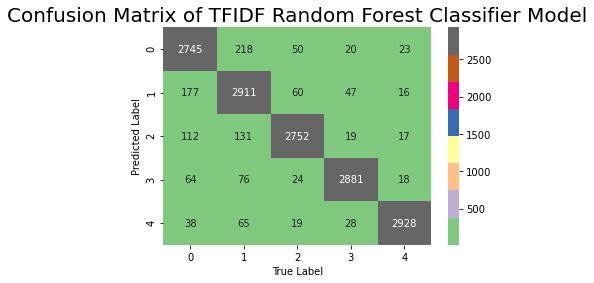

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.88      0.90      0.89      3056\n'
 '           1       0.86      0.91      0.88      3211\n'
 '           2       0.95      0.91      0.93      3031\n'
 '           3       0.96      0.94      0.95      3063\n'
 '           4       0.98      0.95      0.96      3078\n'
 '\n'
 '    accuracy                           0.92     15439\n'
 '   macro avg       0.92      0.92      0.92     15439\n'
 'weighted avg       0.92      0.92      0.92     15439\n')
CPU times: total: 3.78 s
Wall time: 4.27 s


In [55]:
%%time
tfidf_rndm_frst_model = RandomForestClassifier(n_estimators=50)
tfidf_rndm_frst_model, score_tfidf_rfc = evaluate_model(X_train_sv, y_train_sv, X_valid_sv, y_valid_sv, classes, 
                                         tfidf_rndm_frst_model, "TFIDF Random Forest Classifier", "tfidf_rndm_frst_model.pkl", fresh_load=False)

In [56]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_rndm_frst_model = load(open('models/tfidf_rndm_frst_model.pkl', 'rb'))

In [57]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [58]:
%%time
test_acc_scr_tfidf_rfc, df_rottentomatoes_reviews = test_model(tfidf_rndm_frst_model, "TFIDF Random Forest Classifier", "tfidf_rfc", df_rottentomatoes_reviews, test_tfidf_vec_list)

Test Accuracy Score of TFIDF Random Forest Classifier Model created using stemmed tf_idf vector is:
 0.5283018867924528
CPU times: total: 4.67 s
Wall time: 4.67 s


In [59]:
#%%time
#get_cross_val(tfidf_rndm_frst_model, X_train_sv, y_train_sv, X_valid_sv, y_valid_sv)

In [60]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> TFIDF XG-Boost Classifier

Train Accuracy Score of TFIDF XGB Classifier model created using stemmed tf_idf vector is:
 0.9103905837936873
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of TFIDF XGB Classifier model created using stemmed tf_idf vector is:
 0.9050456635792473
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2507  509    5   17   18]
 [  42 3115    9   36    9]
 [   9  374 2625   12   11]
 [   5  197    1 2845   15]
 [   8  167    1   21 2881]]


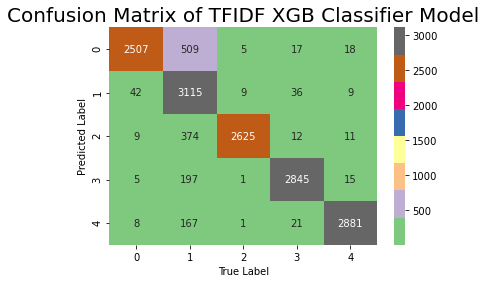

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.98      0.82      0.89      3056\n'
 '           1       0.71      0.97      0.82      3211\n'
 '           2       0.99      0.87      0.93      3031\n'
 '           3       0.97      0.93      0.95      3063\n'
 '           4       0.98      0.94      0.96      3078\n'
 '\n'
 '    accuracy                           0.91     15439\n'
 '   macro avg       0.93      0.90      0.91     15439\n'
 'weighted avg       0.93      0.91      0.91     15439\n')
CPU times: total: 5.86 s
Wall time: 1.45 s


In [61]:
%%time
tfidf_xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc')
tfidf_xgb_model, score_tfidf_xgb = evaluate_model(X_train_sv, y_train_sv, X_valid_sv, y_valid_sv, classes, 
                                         tfidf_xgb_model, "TFIDF XGB Classifier", "tfidf_xgb_model.pkl", fresh_load=False)

In [62]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_xgb_model = load(open('models/tfidf_xgb_model.pkl', 'rb'))

In [63]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [64]:
%%time
test_acc_scr_tfidf_xgb, df_rottentomatoes_reviews = test_model(tfidf_xgb_model, "TFIDF XGB Classifier", "tfidf_xgb", df_rottentomatoes_reviews, test_tfidf_vec_list)

Test Accuracy Score of TFIDF XGB Classifier Model created using stemmed tf_idf vector is:
 0.7320754716981132
CPU times: total: 11.5 s
Wall time: 8.53 s


In [65]:
#%%time
#get_cross_val(tfidf_xgb_model, X_train_sv, y_train_sv, X_valid_sv, y_valid_sv)

In [66]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

In [67]:
score_tfidf= list(deepflatten([score_tfidf_mnb, test_acc_scr_tfidf_mnb, score_tfidf_svc, test_acc_scr_tfidf_svc,
                                 score_tfidf_knn, test_acc_scr_tfidf_knn, score_tfidf_rfc,test_acc_scr_tfidf_rfc,
                                 score_tfidf_xgb, test_acc_scr_tfidf_xgb], depth=1))
score_tfidf = [score_tfidf]

In [68]:
df_score = pd.DataFrame(score_tfidf)
df_score.columns = pd.MultiIndex.from_product([['MNB Accuracy', 'SVC Accuracy', 'KNN Accuracy', 'RFC Accuracy', 'XGB Accuracy'], ['Train','Validate','Test']])
df_score = df_score.set_index([['Basic Vectorisation']])
df_score[df_score.columns] = df_score[df_score.columns].applymap(lambda x: x*100)
df_score[df_score.columns] = df_score[df_score.columns].applymap("{0:.2f}%".format)
df_score

MNB Accuracy                  SVC Accuracy           \
                           Train Validate    Test        Train Validate   
Basic Vectorisation       96.18%   91.54%  74.34%       98.95%   91.72%   

                            KNN Accuracy                  RFC Accuracy  \
                       Test        Train Validate    Test        Train   
Basic Vectorisation  64.91%       64.55%   46.54%  54.72%       99.23%   

                                     XGB Accuracy                   
                    Validate    Test        Train Validate    Test  
Basic Vectorisation   92.08%  52.83%       91.04%   90.50%  73.21%

# <font color='orange'>  <center> Document Embeddings

In [69]:
df_embedding.head()

,lemma_cleaned_tokens,label,label_id
0,"['guardiansofthegalaxy', 'star', 'karengillan'...",Marvel Cinematic Universe,1
1,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...",DC Extended Universe,0
2,"['papa', 'drago', 'godzilla', 'titan', 'omg']",MonsterVerse,2
3,"['batman', 'robin', 'camp']",DC Extended Universe,0
4,"['ant', 'man']",Marvel Cinematic Universe,1


In [70]:
print(list_embedding_data[:5])

['guardiansofthegalaxy star karengillan lot line marvel threequel', 'friend show idea flash guy show watch vote hour pick smt', 'papa drago godzilla titan omg', 'batman robin camp', 'ant man']


In [71]:
w2v_list = [l.split() for l in list_embedding_data]
w2v_model = Word2Vec(w2v_list,
                     vector_size=100,
                     window=5,
                     min_count=2,
                     sg=1)

In [72]:
words = ['star','vader','flash','batman','ironman','thanos','harry','godzilla','kong','king']
for i in range(len(words)):
    print(words[i], end="\t==>  ")
    similar = w2v_model.wv.most_similar(words[i], topn = 10)
    for j in range(len(similar)):
        print(similar[j][0],end =", ")
    print("\n")

star	==>  war, battlefront, nibellion, lswgame, lucasfilm, dlc, zealand, legostarwarstheskywalkersaga, merchandise, steam, 

vader	==>  darth, maul, emperor, lightsaber, saber, prowse, obi, anakin, kenobi, droids, 

flash	==>  cyborg, food, texas, rainfall, price, filmchallenge, coupon, mpd, oklahoma, superman, 

batman	==>  riddler, catwoman, robin, bvs, thebatman, reef, pattinson, arkham, superman, dceu, 

ironman	==>  tonystark, rdj, happybirthdayrobertdowneyjr, titanic, revnant, robertdowneyjr, happybirthdayrdj, sherlock, avengersendgame, chaplin, 

thanos	==>  verybadllama, infinity, gauntlet, snap, smtireland, population, reality, stone, gem, brolin, 

harry	==>  potter, rowling, mcyt, sorteiopromodebooks, harrypotter, goblet, mugglenet, chamber, fcbarcelona, dobby, 

godzilla	==>  kaiju, toho, monsterverse, mechagodzilla, mothra, gamera, anguirus, mecha, ghidorah, gundam, 

kong	==>  ape, godzillavskong, gorilla, king, bundy, kohli, universalpics, babar, donkey, grandpa, 

king	

In [73]:
dump(w2v_model, open("models/w2v_lemma_embedding.model", 'wb'))

In [74]:
w2v_model = Word2Vec.load("models/w2v_lemma_embedding.model")

In [75]:
X_emb = list_embedding_data
y_emb = df_embedding.label_id
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_emb, y_emb, test_size = 0.3, shuffle = True, stratify = y_emb, random_state = 3)

In [76]:
%%time
# load the pre-trained word-embedding vectors 
path = "G:\spark_big_files\\"
glove_file = path + 'glove.42B\glove.42B.300d.txt'
word_vec_file = path + 'wiki-news-300d-1M\wiki-news-300d-1M.vec'

CPU times: total: 0 ns
Wall time: 0 ns


In [77]:
X_emb = pd.Series(list_embedding_data)
y_emb = df_embedding['label_id']
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_emb, y_emb, test_size = 0.3, shuffle = True, stratify = y_emb, random_state = 3)
train_emb = pd.concat([X_train_emb, y_train_emb], axis = 1)
valid_emb = pd.concat([X_valid_emb, y_valid_emb], axis = 1)
train_emb.columns = ['full_text', 'label_id']
valid_emb.columns = ['full_text', 'label_id']

In [78]:
train_emb

,full_text,label_id
15264,art raptorx joschuaknuppe image rex island scute,2
27836,fav godzilla,2
35958,creamycumshotz batman riddler,0
51126,johnxuandou wow series potter queer inclusivit...,4
14670,shitfuckers war gansters,3
...,...,...
31348,mcu marvel fan fun drama,1
28404,hack stay camera woman georgia mcdonalds film ...,3
4636,part memesmonday heard darth jar jar iron star...,3
25655,number people wandavision hawkeye anyone moon ...,1


In [79]:
%%time
glove_vectorizer = GloveVectorizer()

X_train_emb_glv = glove_vectorizer.fit_transform(train_emb.full_text)
y_train_emb_glv = train_emb.label_id

X_valid_emb_glv = glove_vectorizer.transform(valid_emb.full_text)
y_valid_emb_glv = valid_emb.label_id

Loading word vectors...
Found 1917494 word vectors.
Number of samples with no words found: 255 / 36023
Number of samples with no words found: 106 / 15439
CPU times: total: 2min 38s
Wall time: 2min 47s


In [80]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [81]:
%%time
X_test_emb_glv = []
classes = {0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
for i in df_rottentomatoes_reviews.index:
    test_text = df_rottentomatoes_reviews["review"][i]
    test_text = preprocess_doc(test_text, stem = False, lemma = True, stop_wrds = True, selected_tags = selected_tags)
    X_test_emb_glv.append(test_text)
X_test_emb_glv = [" ".join(l) for l in X_test_emb_glv]
X_test_emb_glv = pd.Series(X_test_emb_glv)
X_test_emb_glv[:2]

CPU times: total: 10.6 s
Wall time: 10.6 s


0    godzilla monster thing people love see child g...
1    movie horror maestro comedy script way movie o...
dtype: object

In [82]:
X_test_emb_gv = glove_vectorizer.transform(X_test_emb_glv)
Y_test_emb_gv = df_rottentomatoes_reviews['y_true']

Number of samples with no words found: 0 / 265


# <font color='orange'>  <center> Glove Word Embedding Multinomial Naive Bayes model

In [83]:
%%time
min_max_scaler = MinMaxScaler()
X_train_emb_glv_scaled = min_max_scaler.fit_transform(X_train_emb_glv)
X_valid_emb_glv_scaled = min_max_scaler.transform(X_valid_emb_glv)

CPU times: total: 156 ms
Wall time: 152 ms


------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word Embedding Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.7277850262332399
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word Embedding Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.7369648293283244
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[1700 1293   26   25   12]
 [ 114 3035    5   48    9]
 [  82  825 2099   16    9]
 [  54  568    7 2424   10]
 [  62  836   27   33 2120]]


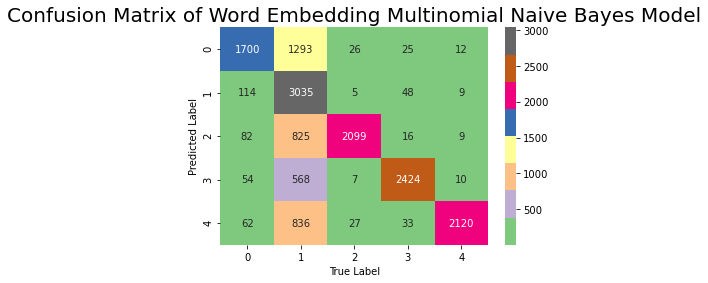

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.84      0.56      0.67      3056\n'
 '           1       0.46      0.95      0.62      3211\n'
 '           2       0.97      0.69      0.81      3031\n'
 '           3       0.95      0.79      0.86      3063\n'
 '           4       0.98      0.69      0.81      3078\n'
 '\n'
 '    accuracy                           0.74     15439\n'
 '   macro avg       0.84      0.73      0.75     15439\n'
 'weighted avg       0.84      0.74      0.75     15439\n')
CPU times: total: 625 ms
Wall time: 525 ms


In [84]:
%%time
we_multi_naive_bayes_model = MultinomialNB()
we_multi_naive_bayes_model, score_we_mnb = evaluate_model(X_train_emb_glv_scaled, y_train_emb_glv, X_valid_emb_glv_scaled, y_valid_emb_glv, classes, 
                                         we_multi_naive_bayes_model, "Word Embedding Multinomial Naive Bayes", "we_glv_multi_naive_bayes_model.pkl", fresh_load=True)

In [85]:
%%time
test_acc_scr_we_mnb, df_rottentomatoes_reviews = test_wrd_emb_model(we_multi_naive_bayes_model, "Word embedded Multinomial Naive Bayes Model", "we_mnb", 
                                                                df_rottentomatoes_reviews, min_max_scaler.transform(X_test_emb_gv))

Test Accuracy Score of Word embedded Multinomial Naive Bayes Model Model created using lemmatized word embedding vector is:
 0.7132075471698113
CPU times: total: 0 ns
Wall time: 4.99 ms


In [86]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Glove Word Embedding Support Vector Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word Embedding Support Vector Classifier model created using stemmed tf_idf vector is:
 0.9091691419370957
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word Embedding Support Vector Classifier model created using stemmed tf_idf vector is:
 0.8792667918906665
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2619  284   78   30   45]
 [ 263 2758   71   62   57]
 [ 182  191 2605   20   33]
 [  86   84   29 2834   30]
 [ 143  118   26   32 2759]]


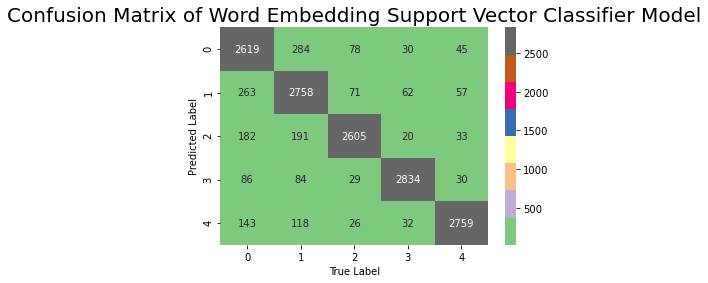

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.80      0.86      0.83      3056\n'
 '           1       0.80      0.86      0.83      3211\n'
 '           2       0.93      0.86      0.89      3031\n'
 '           3       0.95      0.93      0.94      3063\n'
 '           4       0.94      0.90      0.92      3078\n'
 '\n'
 '    accuracy                           0.88     15439\n'
 '   macro avg       0.88      0.88      0.88     15439\n'
 'weighted avg       0.88      0.88      0.88     15439\n')
CPU times: total: 5min 59s
Wall time: 6min


In [87]:
%%time
we_svc_model = SVC(kernel='rbf')
we_svc_model, score_we_svc = evaluate_model(X_train_emb_glv, y_train_emb_glv, X_valid_emb_glv, y_valid_emb_glv, classes, 
                                         we_svc_model, "Word Embedding Support Vector Classifier", "we_glv_svc_model.pkl", fresh_load=True)

In [88]:
%%time
test_acc_scr_we_svc, df_rottentomatoes_reviews = test_wrd_emb_model(we_svc_model, "Word Embedding Support Vector Classifier", "we_svc", 
                                                                df_rottentomatoes_reviews, X_test_emb_gv)

Test Accuracy Score of Word Embedding Support Vector Classifier Model created using lemmatized word embedding vector is:
 0.8943396226415095
CPU times: total: 906 ms
Wall time: 908 ms


In [89]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Glove Word Embedding K-Nearest Neighbor(KNN)

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word Embedding K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.876717652610832
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word Embedding K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.8194831271455405
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2320  468  110   85   73]
 [ 359 2566  103  110   73]
 [ 220  268 2430   68   45]
 [  96  140   44 2751   32]
 [ 190  165   65   73 2585]]


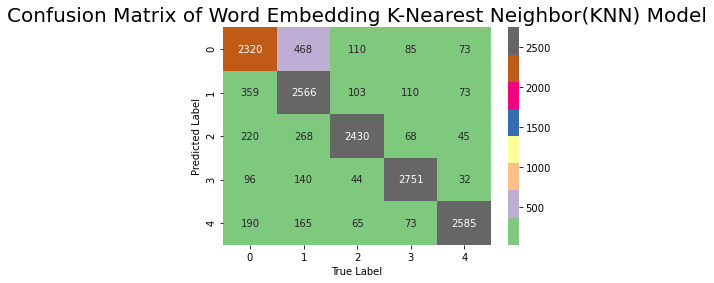

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.73      0.76      0.74      3056\n'
 '           1       0.71      0.80      0.75      3211\n'
 '           2       0.88      0.80      0.84      3031\n'
 '           3       0.89      0.90      0.89      3063\n'
 '           4       0.92      0.84      0.88      3078\n'
 '\n'
 '    accuracy                           0.82     15439\n'
 '   macro avg       0.83      0.82      0.82     15439\n'
 'weighted avg       0.83      0.82      0.82     15439\n')
CPU times: total: 2min 57s
Wall time: 1min 7s


In [90]:
%%time
we_knn_model = KNeighborsClassifier(5)
we_knn_model, score_we_knn = evaluate_model(X_train_emb_glv, y_train_emb_glv, X_valid_emb_glv, y_valid_emb_glv, classes, 
                                         we_knn_model, "Word Embedding K-Nearest Neighbor(KNN)", "we_glv_knn_model.pkl", fresh_load=True)

In [91]:
%%time
test_acc_scr_we_knn, df_rottentomatoes_reviews = test_wrd_emb_model(we_knn_model, "Word Embedding K-Nearest Neighbor(KNN)", "we_knn", 
                                                                df_rottentomatoes_reviews, X_test_emb_gv)

Test Accuracy Score of Word Embedding K-Nearest Neighbor(KNN) Model created using lemmatized word embedding vector is:
 0.7320754716981132
CPU times: total: 656 ms
Wall time: 321 ms


In [92]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Glove Word Embedding Random Forest Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word Embedding Random Forest Classifier model created using stemmed tf_idf vector is:
 0.9869527801682259
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word Embedding Random Forest Classifier model created using stemmed tf_idf vector is:
 0.8518038733078567
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2499  423   56   28   50]
 [ 288 2784   38   57   44]
 [ 222  272 2487   21   29]
 [ 119  145   22 2752   25]
 [ 170  216   25   38 2629]]


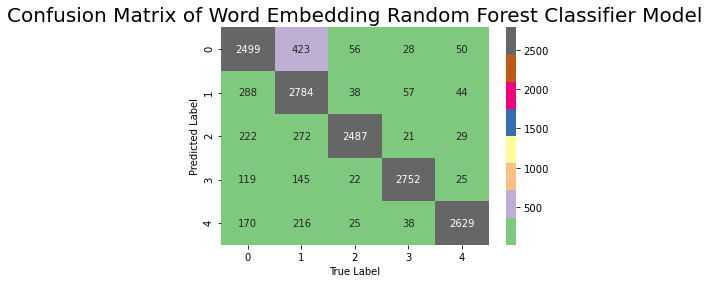

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.76      0.82      0.79      3056\n'
 '           1       0.72      0.87      0.79      3211\n'
 '           2       0.95      0.82      0.88      3031\n'
 '           3       0.95      0.90      0.92      3063\n'
 '           4       0.95      0.85      0.90      3078\n'
 '\n'
 '    accuracy                           0.85     15439\n'
 '   macro avg       0.87      0.85      0.86     15439\n'
 'weighted avg       0.86      0.85      0.85     15439\n')
CPU times: total: 2min
Wall time: 2min


In [93]:
%%time
we_rndm_frst_model = RandomForestClassifier(n_estimators=200)
we_rndm_frst_model, score_we_rfc = evaluate_model(X_train_emb_glv, y_train_emb_glv, X_valid_emb_glv, y_valid_emb_glv, classes, 
                                         we_rndm_frst_model, "Word Embedding Random Forest Classifier", "we_glv_rndm_frst_model.pkl", fresh_load=True)

In [94]:
%%time
test_acc_scr_we_rfc, df_rottentomatoes_reviews = test_wrd_emb_model(we_rndm_frst_model, "Word Embedding Random Forest Classifier", "we_rfc", 
                                                                df_rottentomatoes_reviews, X_test_emb_gv)

Test Accuracy Score of Word Embedding Random Forest Classifier Model created using lemmatized word embedding vector is:
 0.8339622641509434
CPU times: total: 46.9 ms
Wall time: 50.3 ms


In [95]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Glove Word Embedding XGB Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word Embedding XGB Classifier model created using stemmed tf_idf vector is:
 0.9843710962440663
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word Embedding XGB Classifier model created using stemmed tf_idf vector is:
 0.8635274305330656
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2540  323   97   32   64]
 [ 278 2726   89   55   63]
 [ 185  198 2572   33   43]
 [  96  105   32 2790   40]
 [ 143  154   42   35 2704]]


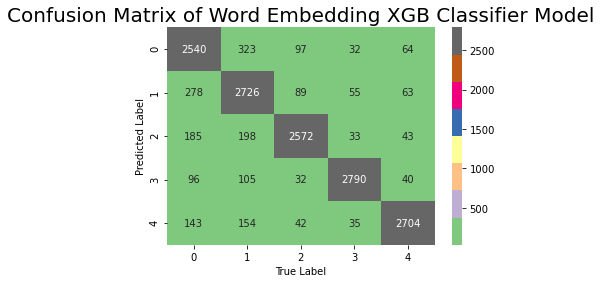

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.78      0.83      0.81      3056\n'
 '           1       0.78      0.85      0.81      3211\n'
 '           2       0.91      0.85      0.88      3031\n'
 '           3       0.95      0.91      0.93      3063\n'
 '           4       0.93      0.88      0.90      3078\n'
 '\n'
 '    accuracy                           0.86     15439\n'
 '   macro avg       0.87      0.86      0.87     15439\n'
 'weighted avg       0.87      0.86      0.86     15439\n')
CPU times: total: 44min 5s
Wall time: 5min 51s


In [96]:
%%time
we_xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc')
we_xgb_model, score_we_xgb = evaluate_model(X_train_emb_glv, y_train_emb_glv, X_valid_emb_glv, y_valid_emb_glv, classes, 
                                         we_xgb_model, "Word Embedding XGB Classifier", "we_glv_xgb_model.pkl", fresh_load=True)

In [97]:
%%time
test_acc_scr_we_xgb, df_rottentomatoes_reviews = test_wrd_emb_model(we_xgb_model, "Word Embedding XGB Classifier", "we_xgb", 
                                                                df_rottentomatoes_reviews, X_test_emb_gv)

Test Accuracy Score of Word Embedding XGB Classifier Model created using lemmatized word embedding vector is:
 0.8566037735849057
CPU times: total: 46.9 ms
Wall time: 13.1 ms


In [98]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

In [99]:
score_we = list(deepflatten([score_we_mnb, test_acc_scr_we_mnb, score_we_svc, test_acc_scr_we_svc,
                                 score_we_knn, test_acc_scr_we_knn, score_we_rfc,test_acc_scr_we_rfc,
                                 score_we_xgb, test_acc_scr_we_xgb], depth=1))
score_we = [score_we]

In [100]:
df_score_we = pd.DataFrame(score_we)
df_score_we.columns = pd.MultiIndex.from_product([['MNB Accuracy', 'SVC Accuracy', 'KNN Accuracy', 'RFC Accuracy', 'XGB Accuracy'], ['Train','Validate','Test']])
df_score_we = df_score_we.set_index([['Word Embedding Glove']])
df_score_we[df_score_we.columns] = df_score_we[df_score_we.columns].applymap(lambda x: x*100)
df_score_we[df_score_we.columns] = df_score_we[df_score_we.columns].applymap("{0:.2f}%".format)
df_score_we

MNB Accuracy                  SVC Accuracy           \
                            Train Validate    Test        Train Validate   
Word Embedding Glove       72.78%   73.70%  71.32%       90.92%   87.93%   

                             KNN Accuracy                  RFC Accuracy  \
                        Test        Train Validate    Test        Train   
Word Embedding Glove  89.43%       87.67%   81.95%  73.21%       98.70%   

                                      XGB Accuracy                   
                     Validate    Test        Train Validate    Test  
Word Embedding Glove   85.18%  83.40%       98.44%   86.35%  85.66%

# <font color='orange'>  <center> Word2Vec Word Embedding

In [101]:
%%time
w2v_vectorizer = Word2VecVectorizer()

X_train_emb_w2v = w2v_vectorizer.fit_transform(train_emb.full_text)
y_train_emb_w2v = train_emb.label_id

X_valid_emb_w2v = w2v_vectorizer.transform(valid_emb.full_text)
y_valid_emb_w2v = valid_emb.label_id

Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 627 / 36023
Number of samples with no words found: 287 / 15439
CPU times: total: 40.7 s
Wall time: 1min 1s


In [102]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [103]:
%%time
X_test_emb_w2v = []
classes = {0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
for i in df_rottentomatoes_reviews.index:
    test_text = df_rottentomatoes_reviews["review"][i]
    test_text = preprocess_doc(test_text, stem = False, lemma = True, stop_wrds = True, selected_tags = selected_tags)
    X_test_emb_w2v.append(test_text)
X_test_emb_w2v = [" ".join(l) for l in X_test_emb_w2v]
X_test_emb_w2v = pd.Series(X_test_emb_w2v)
X_test_emb_w2v[:2]

CPU times: total: 10.7 s
Wall time: 10.9 s


0    godzilla monster thing people love see child g...
1    movie horror maestro comedy script way movie o...
dtype: object

In [104]:
X_test_emb_w2v = w2v_vectorizer.transform(X_test_emb_w2v)
Y_test_emb_w2v = df_rottentomatoes_reviews['y_true']

Number of samples with no words found: 0 / 265


# <font color='orange'>  <center> Word2Vec Word Embedding Multinomial Naive Bayes model

In [105]:
%%time
min_max_scaler = MinMaxScaler()
X_train_emb_w2v_scaled = min_max_scaler.fit_transform(X_train_emb_w2v)
X_valid_emb_w2v_scaled = min_max_scaler.transform(X_valid_emb_w2v)

CPU times: total: 141 ms
Wall time: 150 ms


------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word2Vec Word Embedding Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.6160508563973017
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word2Vec Word Embedding Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.6212837619016776
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[1368 1539   48   67   34]
 [  86 2938   58   92   37]
 [  50 1347 1502   98   34]
 [  36  826   46 2135   20]
 [  44 1248   79   58 1649]]


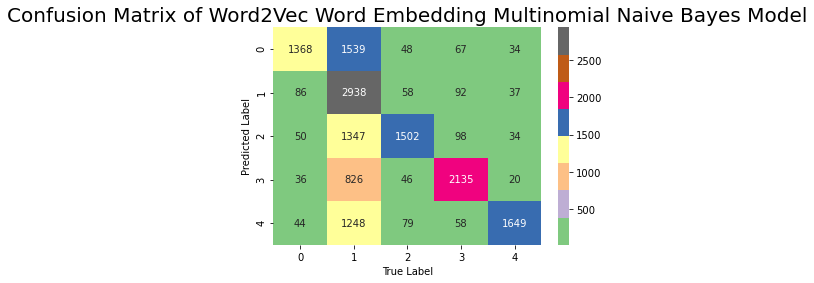

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.86      0.45      0.59      3056\n'
 '           1       0.37      0.91      0.53      3211\n'
 '           2       0.87      0.50      0.63      3031\n'
 '           3       0.87      0.70      0.77      3063\n'
 '           4       0.93      0.54      0.68      3078\n'
 '\n'
 '    accuracy                           0.62     15439\n'
 '   macro avg       0.78      0.62      0.64     15439\n'
 'weighted avg       0.78      0.62      0.64     15439\n')
CPU times: total: 609 ms
Wall time: 769 ms


In [106]:
%%time
we_w2v_multi_naive_bayes_model = MultinomialNB()
we_w2v_multi_naive_bayes_model, score_we_w2v_mnb = evaluate_model(X_train_emb_w2v_scaled, y_train_emb_w2v, X_valid_emb_w2v_scaled, y_valid_emb_w2v, classes, 
                                         we_w2v_multi_naive_bayes_model, "Word2Vec Word Embedding Multinomial Naive Bayes", "we_w2v_multi_naive_bayes_model.pkl", fresh_load=True)

In [107]:
%%time
test_acc_scr_we_w2v_mnb, df_rottentomatoes_reviews = test_wrd_emb_model(we_w2v_multi_naive_bayes_model, "Word embedded Multinomial Naive Bayes Model", "we_w2v_mnb", 
                                                                df_rottentomatoes_reviews, min_max_scaler.transform(X_test_emb_w2v))

Test Accuracy Score of Word embedded Multinomial Naive Bayes Model Model created using lemmatized word embedding vector is:
 0.6566037735849056
CPU times: total: 15.6 ms
Wall time: 19.4 ms


In [108]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Word2Vec Word Embedding Support Vector Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word2Vec Word Embedding Support Vector Classifier model created using stemmed tf_idf vector is:
 0.8879327096577186
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word2Vec Word Embedding Support Vector Classifier model created using stemmed tf_idf vector is:
 0.8231750761059654
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2403  394  131   36   92]
 [ 198 2680  131   63  139]
 [ 167  316 2403   44  101]
 [  78  171   51 2704   59]
 [ 114  295  107   43 2519]]


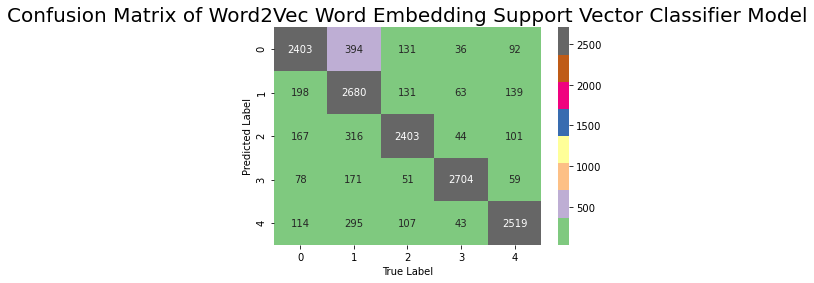

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.81      0.79      0.80      3056\n'
 '           1       0.70      0.83      0.76      3211\n'
 '           2       0.85      0.79      0.82      3031\n'
 '           3       0.94      0.88      0.91      3063\n'
 '           4       0.87      0.82      0.84      3078\n'
 '\n'
 '    accuracy                           0.82     15439\n'
 '   macro avg       0.83      0.82      0.83     15439\n'
 'weighted avg       0.83      0.82      0.83     15439\n')
CPU times: total: 8min 30s
Wall time: 8min 31s


In [109]:
%%time
we_w2v_svc_model = SVC(kernel='rbf')
we_w2v_svc_model, score_we_w2v_svc = evaluate_model(X_train_emb_w2v, y_train_emb_w2v, X_valid_emb_w2v, y_valid_emb_w2v, classes, 
                                         we_w2v_svc_model, "Word2Vec Word Embedding Support Vector Classifier", "we_w2v_svc_model.pkl", fresh_load=True)

In [110]:
%%time
test_acc_scr_we_w2v_svc, df_rottentomatoes_reviews = test_wrd_emb_model(we_w2v_svc_model, "Word2Vec Word Embedding Support Vector Classifier", "we_w2v_svc", 
                                                                df_rottentomatoes_reviews, X_test_emb_w2v)

Test Accuracy Score of Word2Vec Word Embedding Support Vector Classifier Model created using lemmatized word embedding vector is:
 0.8226415094339623
CPU times: total: 1.27 s
Wall time: 1.26 s


In [111]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Word2Vec Word Embedding K-Nearest Neighbor(KNN)

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word2Vec Word Embedding K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.8090664297809733
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word2Vec Word Embedding K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.7305524969233759
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2174  475  172  136   99]
 [ 377 2322  233  187   92]
 [ 289  536 1956  166   84]
 [ 108  229   81 2600   45]
 [ 202  350  165  134 2227]]


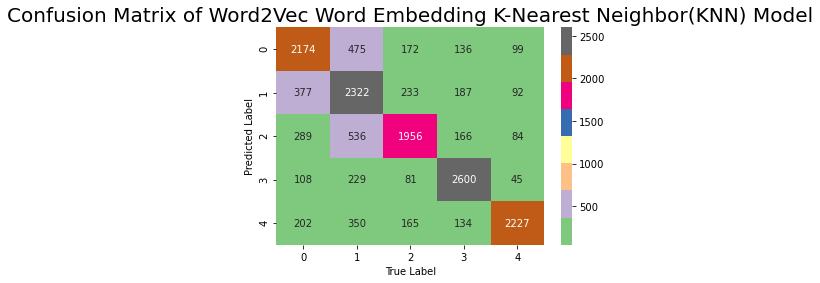

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.69      0.71      0.70      3056\n'
 '           1       0.59      0.72      0.65      3211\n'
 '           2       0.75      0.65      0.69      3031\n'
 '           3       0.81      0.85      0.83      3063\n'
 '           4       0.87      0.72      0.79      3078\n'
 '\n'
 '    accuracy                           0.73     15439\n'
 '   macro avg       0.74      0.73      0.73     15439\n'
 'weighted avg       0.74      0.73      0.73     15439\n')
CPU times: total: 2min 55s
Wall time: 1min 10s


In [112]:
%%time
we_w2v_knn_model = KNeighborsClassifier(5)
we_w2v_knn_model, score_we_w2v_knn = evaluate_model(X_train_emb_w2v, y_train_emb_w2v, X_valid_emb_w2v, y_valid_emb_w2v, classes, 
                                         we_w2v_knn_model, "Word2Vec Word Embedding K-Nearest Neighbor(KNN)", "we_w2v_knn_model.pkl", fresh_load=True)

In [113]:
%%time
test_acc_scr_we_w2v_knn, df_rottentomatoes_reviews = test_wrd_emb_model(we_w2v_knn_model, "Word2Vec Word Embedding K-Nearest Neighbor(KNN)", "we_w2v_knn", 
                                                                df_rottentomatoes_reviews, X_test_emb_w2v)

Test Accuracy Score of Word2Vec Word Embedding K-Nearest Neighbor(KNN) Model created using lemmatized word embedding vector is:
 0.7132075471698113
CPU times: total: 734 ms
Wall time: 296 ms


In [114]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Word2Vec Word Embedding Random Forest Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word2Vec Word Embedding Random Forest Classifier model created using stemmed tf_idf vector is:
 0.9752935624462149
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word2Vec Word Embedding Random Forest Classifier model created using stemmed tf_idf vector is:
 0.7699980568689682
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2226  554  168   43   65]
 [ 241 2665  168   75   62]
 [ 180  440 2307   53   51]
 [ 133  286  129 2468   47]
 [ 179  458  171   48 2222]]


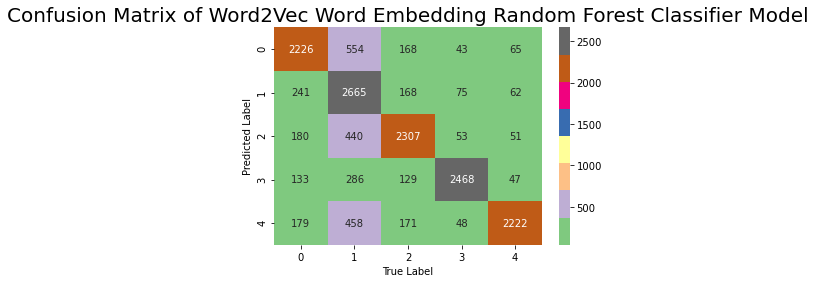

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.75      0.73      0.74      3056\n'
 '           1       0.61      0.83      0.70      3211\n'
 '           2       0.78      0.76      0.77      3031\n'
 '           3       0.92      0.81      0.86      3063\n'
 '           4       0.91      0.72      0.80      3078\n'
 '\n'
 '    accuracy                           0.77     15439\n'
 '   macro avg       0.79      0.77      0.78     15439\n'
 'weighted avg       0.79      0.77      0.77     15439\n')
CPU times: total: 1min 58s
Wall time: 2min 4s


In [115]:
%%time
we_w2v_rndm_frst_model = RandomForestClassifier(n_estimators=200)
we_w2v_rndm_frst_model, score_we_w2v_rfc = evaluate_model(X_train_emb_w2v, y_train_emb_w2v, X_valid_emb_w2v, y_valid_emb_w2v, classes, 
                                         we_w2v_rndm_frst_model, "Word2Vec Word Embedding Random Forest Classifier", "we_w2v_rndm_frst_model.pkl", fresh_load=True)

In [116]:
%%time
test_acc_scr_we_w2v_rfc, df_rottentomatoes_reviews = test_wrd_emb_model(we_w2v_rndm_frst_model, "Word2Vec Word Embedding Random Forest Classifier", "we_w2v_rfc", 
                                                                df_rottentomatoes_reviews, X_test_emb_w2v)

Test Accuracy Score of Word2Vec Word Embedding Random Forest Classifier Model created using lemmatized word embedding vector is:
 0.7660377358490567
CPU times: total: 46.9 ms
Wall time: 41 ms


In [117]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Word2Vec Word Embedding XGB Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word2Vec Word Embedding XGB Classifier model created using stemmed tf_idf vector is:
 0.9655497876356772
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word2Vec Word Embedding XGB Classifier model created using stemmed tf_idf vector is:
 0.7890407409806335
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2320  437  169   48   82]
 [ 251 2569  200   78  113]
 [ 174  371 2330   58   98]
 [ 108  196   97 2590   72]
 [ 172  339  138   56 2373]]


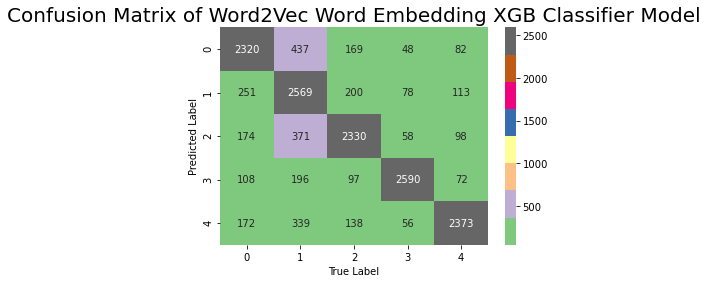

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.77      0.76      0.76      3056\n'
 '           1       0.66      0.80      0.72      3211\n'
 '           2       0.79      0.77      0.78      3031\n'
 '           3       0.92      0.85      0.88      3063\n'
 '           4       0.87      0.77      0.82      3078\n'
 '\n'
 '    accuracy                           0.79     15439\n'
 '   macro avg       0.80      0.79      0.79     15439\n'
 'weighted avg       0.80      0.79      0.79     15439\n')
CPU times: total: 40min 1s
Wall time: 5min 14s


In [118]:
%%time
we_w2v_xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc')
we_w2v_xgb_model, score_we_w2v_xgb = evaluate_model(X_train_emb_w2v, y_train_emb_w2v, X_valid_emb_w2v, y_valid_emb_w2v, classes, 
                                         we_w2v_xgb_model, "Word2Vec Word Embedding XGB Classifier", "we_w2v_xgb_model.pkl", fresh_load=True)

In [119]:
%%time
test_acc_scr_we_w2v_xgb, df_rottentomatoes_reviews = test_wrd_emb_model(we_w2v_xgb_model, "Word2Vec Word Embedding XGB Classifier", "we_w2v_xgb", 
                                                                df_rottentomatoes_reviews, X_test_emb_w2v)

Test Accuracy Score of Word2Vec Word Embedding XGB Classifier Model created using lemmatized word embedding vector is:
 0.7773584905660378
CPU times: total: 93.8 ms
Wall time: 8.03 ms


In [120]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

In [121]:
score_we_w2v = list(deepflatten([score_we_w2v_mnb, test_acc_scr_we_w2v_mnb, score_we_w2v_svc, test_acc_scr_we_w2v_svc,
                                 score_we_w2v_knn, test_acc_scr_we_w2v_knn, score_we_w2v_rfc,test_acc_scr_we_w2v_rfc,
                                 score_we_w2v_xgb, test_acc_scr_we_w2v_xgb], depth=1))
score_we_w2v = [score_we_w2v]

In [122]:
df_score_we_w2v = pd.DataFrame(score_we_w2v)
df_score_we_w2v.columns = pd.MultiIndex.from_product([['MNB Accuracy', 'SVC Accuracy', 'KNN Accuracy', 'RFC Accuracy', 'XGB Accuracy'], ['Train','Validate','Test']])
df_score_we_w2v = df_score_we_w2v.set_index([['Word Embedding Word2Vec']])
df_score_we_w2v[df_score_we_w2v.columns] = df_score_we_w2v[df_score_we_w2v.columns].applymap(lambda x: x*100)
df_score_we_w2v[df_score_we_w2v.columns] = df_score_we_w2v[df_score_we_w2v.columns].applymap("{0:.2f}%".format)
df_score_we_w2v

MNB Accuracy                  SVC Accuracy           \
                               Train Validate    Test        Train Validate   
Word Embedding Word2Vec       61.61%   62.13%  65.66%       88.79%   82.32%   

                                KNN Accuracy                  RFC Accuracy  \
                           Test        Train Validate    Test        Train   
Word Embedding Word2Vec  82.26%       80.91%   73.06%  71.32%       97.53%   

                                         XGB Accuracy                   
                        Validate    Test        Train Validate    Test  
Word Embedding Word2Vec   77.00%  76.60%       96.55%   78.90%  77.74%

In [123]:
final_accuracy_df = pd.concat([df_score, df_score_we, df_score_we_w2v])
final_accuracy_df

MNB Accuracy                  SVC Accuracy           \
                               Train Validate    Test        Train Validate   
Basic Vectorisation           96.18%   91.54%  74.34%       98.95%   91.72%   
Word Embedding Glove          72.78%   73.70%  71.32%       90.92%   87.93%   
Word Embedding Word2Vec       61.61%   62.13%  65.66%       88.79%   82.32%   

                                KNN Accuracy                  RFC Accuracy  \
                           Test        Train Validate    Test        Train   
Basic Vectorisation      64.91%       64.55%   46.54%  54.72%       99.23%   
Word Embedding Glove     89.43%       87.67%   81.95%  73.21%       98.70%   
Word Embedding Word2Vec  82.26%       80.91%   73.06%  71.32%       97.53%   

                                         XGB Accuracy                   
                        Validate    Test        Train Validate    Test  
Basic Vectorisation       92.08%  52.83%       91.04%   90.50%  73.21%  
Word Embedding Glove      85.18%  83.40%       98.44%   86.35%  85.66%  
Word Embedding Word2Vec   77.00%  76.60%       96.55%   78.90%  77.74%

In [124]:
final_accuracy_df.to_csv("output/final_accuracy_final.csv")